In [1]:
!pip install lightfm

  Using cached lightfm-1.16-cp36-cp36m-linux_x86_64.whl
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import json
from pandas.io.json import json_normalize
import numpy as np
from scipy import sparse
from scipy.sparse import csr_matrix, coo_matrix
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k

## Processing data

In [3]:
data = [json.loads(line) for line in open('raw_data.json', 'r')]

In [4]:
df = pd.json_normalize(data)

In [29]:
df.customerVisitorId.nunique()

44876

In [ ]:
df.columns

Index(['customerId', 'customerArea', 'customerVisitorId', 'customerLoginId',
       'customerSessionId', 'sessionStartTime', 'sessionEndTime',
       'customerSessionNumber', 'hits', 'totals.timeOnSite', 'totals.events',
       'totals.newSession', 'totals.bounce', 'totals.totalSearches',
       'totals.totalNavigations', 'totals.totalRefinements',
       'totals.totalViewProducts', 'totals.totalViewProductRevenue',
       'totals.totalNullSearches', 'totals.uniqueViewProducts',
       'trafficSource.gbiFlag', 'trafficSource.deviceCategory',
       'trafficSource.device', 'trafficSource.browser', 'trafficSource.os',
       'trafficSource.userAgent', 'trafficSource.language',
       'trafficSource.page', 'trafficSource.city', 'trafficSource.region',
       'trafficSource.country', 'trafficSource.campaign',
       'trafficSource.source', 'trafficSource.medium', 'trafficSource.content',
       'totals.totalAddToCarts', 'totals.totalAddToCartQty',
       'totals.totalAddToCartRevenue', 'to

In [5]:
cols = ['customerVisitorId', 'customerSessionId','sessionStartTime', 'sessionEndTime', 'customerSessionNumber']

In [6]:
hits = pd.json_normalize(data, record_path=['hits', 'product'], meta=cols)

In [8]:
hits[hits.customerVisitorId=='cki8pfl1y000139ebdeezn6pn']

,sku,ID,name,price,collection,attributedSearches,quantity,listLocation,listPosition,customerVisitorId,customerSessionId,sessionStartTime,sessionEndTime,customerSessionNumber
1474200,SWA051,SWA051,dr. stephen langer's ultimate 16 strain probio...,14.79,Swanson Probiotics,[],NaN,NaN,NaN,cki8pfl1y000139ebdeezn6pn,cki8pfl1y000139ebdeezn6pn1606894616,2020-12-02 07:36:56.522423 UTC,2020-12-02 07:40:45.201722 UTC,1
1474201,SWA051,SWA051,dr. stephen langer's ultimate 16 strain probio...,14.79,default,[],NaN,NaN,NaN,cki8pfl1y000139ebdeezn6pn,cki8pfl1y000139ebdeezn6pn1606894616,2020-12-02 07:36:56.522423 UTC,2020-12-02 07:40:45.201722 UTC,1
1474202,SWA051,SWA051,dr. stephen langer's ultimate 16 strain probio...,14.79,default,[],3,NaN,NaN,cki8pfl1y000139ebdeezn6pn,cki8pfl1y000139ebdeezn6pn1606894616,2020-12-02 07:36:56.522423 UTC,2020-12-02 07:40:45.201722 UTC,1
1474203,SWA051,SWA051,3.2 billion cfu 60 veg drcaps,14.79,Swanson Probiotics,[],3,NaN,NaN,cki8pfl1y000139ebdeezn6pn,cki8pfl1y000139ebdeezn6pn1606894616,2020-12-02 07:36:56.522423 UTC,2020-12-02 07:40:45.201722 UTC,1


In [103]:
hits.collection.value_counts()

swansonhealthproduction    1573529
default                      36134
Swanson Premium              17705
Swanson Ultra                11953
NOW Foods                     6493
                            ...   
Atkins                           1
Dr. Linus Pauling                1
EFX Sports                       1
Aaraam                           1
Red Ace                          1
Name: collection, Length: 905, dtype: int64

In [7]:
all_cols = df.columns[df.columns.str.contains('totals')].tolist() + cols

In [8]:
df_merged = df[all_cols].merge(hits, how='left', on=cols)

In [12]:
df_merged[df_merged.customerVisitorId=='cki8pfl1y000139ebdeezn6pn'][['ID', 'name', 'price', 'totals.totalOrders', 'totals.totalOrderQty', 'customerSessionId', 'customerSessionNumber', 'totals.uniqueOrders', 'totals.totalViewProducts', 'totals.totalAddToCarts']]

,ID,name,price,totals.totalOrders,totals.totalOrderQty,customerSessionId,customerSessionNumber,totals.uniqueOrders,totals.totalViewProducts,totals.totalAddToCarts
1474537,SWA051,dr. stephen langer's ultimate 16 strain probio...,14.79,1,3,cki8pfl1y000139ebdeezn6pn1606894616,1,1,2,1
1474538,SWA051,dr. stephen langer's ultimate 16 strain probio...,14.79,1,3,cki8pfl1y000139ebdeezn6pn1606894616,1,1,2,1
1474539,SWA051,dr. stephen langer's ultimate 16 strain probio...,14.79,1,3,cki8pfl1y000139ebdeezn6pn1606894616,1,1,2,1
1474540,SWA051,3.2 billion cfu 60 veg drcaps,14.79,1,3,cki8pfl1y000139ebdeezn6pn1606894616,1,1,2,1


(array([1.23361e+05, 1.46570e+04, 2.08600e+03, 4.64000e+02, 9.60000e+01,
        4.90000e+01, 5.00000e+00, 1.00000e+00, 8.00000e+00, 9.00000e+00]),
 array([  0.66 ,  23.914,  47.168,  70.422,  93.676, 116.93 , 140.184,
        163.438, 186.692, 209.946, 233.2  ]),
 <a list of 10 Patch objects>)

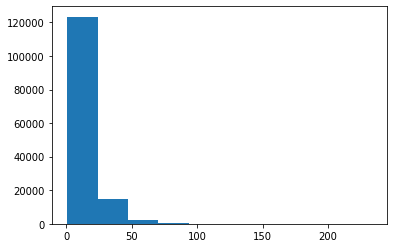

In [ ]:
plt.hist(hits.price)

### Filter price

In [80]:
df_merged2 = df_merged[(df_merged.price>=11) & (df_merged.price<=24)] 

In [ ]:
md = np.median(hits[~hits.price.isnull()].price)

In [ ]:
len(hits['price'])

1714266

In [9]:
df_rm_dup = df_merged.drop_duplicates(['customerVisitorId', 'ID', 'price', 'customerSessionId'])

In [19]:
df_rm_dup.collection.value_counts(normalize=True)

swansonhealthproduction    9.164339e-01
Swanson Premium            1.230345e-02
Swanson Ultra              8.300530e-03
default                    6.516277e-03
NOW Foods                  4.755789e-03
                               ...     
Ostrim                     9.505875e-07
Inholtra                   9.505875e-07
Maximum International      9.505875e-07
Baie Run                   9.505875e-07
Superfood For Skin         9.505875e-07
Name: collection, Length: 905, dtype: float64

In [15]:
df_rm_dup[['ID', 'price', 'collection', 'name']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1052318 entries, 0 to 1714602
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   ID          1051981 non-null  object 
 1   price       87909 non-null    float64
 2   collection  1051981 non-null  object 
 3   name        87910 non-null    object 
dtypes: float64(1), object(3)
memory usage: 40.1+ MB


In [55]:
df_rm_dup[df_rm_dup.name.isnull()].ID

2441          NaN
2442       CSN193
2443          NaN
2444       SWF116
2445       SWF068
            ...  
1714334    CRL396
1714335    SW1453
1714336    SWU248
1714337    NWF270
1714338    NWF139
Name: ID, Length: 964408, dtype: object

### Create dictionary of item ID, name, price, collection

In [106]:
mult_collection = df_rm_dup.groupby('ID')['collection'].nunique().sort_values(ascending=False).reset_index()

In [112]:
mult_collection

,ID,collection
0,SW923,7
1,SW1371,6
2,SW1113,6
3,SWA051,6
4,SW1782,6
...,...,...
17475,KND004,1
17476,SN135,1
17477,NWF1044,1
17478,SN132,1


In [117]:
hits[hits.ID=='SW923'].collection.unique()

array(['swansonhealthproduction', 'Swanson Premium', 'default', 'Kal',
       'Life Extension', 'Swanson Ultra', 'Swanson Superior Herbs'],
      dtype=object)

In [119]:
dic = {}
for i in range(len(df_rm_dup)):
    prod = df_rm_dup.iloc[i]
    if prod.ID not in dic.keys() and str(prod.sku) != 'nan':
        dic[prod.ID] = {}
        dic[prod.ID]['name'] = prod['name']
        dic[prod.ID]['collection'] = prod.collection
        dic[prod.ID]['price'] = prod.price

In [10]:
df_rm_dup['totals.totalOrderQty'] = df_rm_dup['totals.totalOrderQty'].fillna(0)
df_rm_dup['totals.totalOrderQty'] = df_rm_dup['totals.totalOrderQty'].astype(int)
num_purchase = df_rm_dup.groupby(['customerVisitorId', 'ID']).agg({'totals.totalOrderQty':'sum', 'price':'mean', 'customerSessionId':'nunique', 'collection':'first'})
num_purchase = num_purchase.reset_index().rename(columns={"totals.totalOrderQty":"numPurchase"})
num_purchase['Purchase'] = num_purchase.numPurchase.apply(lambda x: 1 if x!=0 else 0)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [89]:
cust_collection = num_purchase.groupby("customerVisitorId")['collection'].apply(list).reset_index()

In [94]:
cust_collection['contains_swansonhealth'] = cust_collection['collection'].apply(lambda x: 'swansonhealthproduction' not in x)

In [ ]:
num_purchase['price'] = np.where(num_purchase.price.isnull(), md, num_purchase.price)

In [11]:
num_purchase['price_category'] = np.where(num_purchase.price>=94, 'very expensive', np.where((num_purchase.price>= 48) & (num_purchase.price<94), 'expensive', np.where((num_purchase.price>= 24) & (num_purchase.price<48), 'medium', 'cheap')))

In [11]:
num_purchase.head()

,customerVisitorId,ID,numPurchase,price,customerSessionId,collection,Purchase
0,cjo06cah000013ea3jqwotb8g,AAM013,0,NaN,2,swansonhealthproduction,0
1,cjo06cah000013ea3jqwotb8g,AAM016,0,NaN,2,swansonhealthproduction,0
2,cjo06cah000013ea3jqwotb8g,AAM019,0,NaN,2,swansonhealthproduction,0
3,cjo06cah000013ea3jqwotb8g,ARG010,0,NaN,2,swansonhealthproduction,0
4,cjo06cah000013ea3jqwotb8g,DB088,0,NaN,2,swansonhealthproduction,0


## Analysis of product price category and number of sessions with regards to purchase

In [45]:
num_purchase[num_purchase.Purchase==1].groupby('price_category')['customerSessionId'].mean()

price_category
cheap             1.019692
expensive         1.066176
medium            1.090868
very expensive    1.000000
Name: customerSessionId, dtype: float64

Text(0.5, 1.0, 'Groupby Data Filter by Category')

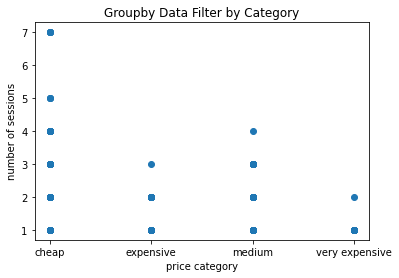

In [117]:
plt.scatter(num_purchase[(num_purchase.collection=='swansonhealthproduction')].price_category, num_purchase[num_purchase.collection=='swansonhealthproduction'].customerSessionId)
plt.xlabel('price category')
plt.ylabel('number of sessions')
plt.title('Groupby Data Filter by Category')

In [102]:
num_purchase[(num_purchase.Purchase==1) & (num_purchase.price>=11) & (num_purchase.price<=24)].ID.nunique()

2649

In [49]:
num_purchase.groupby('price_category')['ID'].count()

price_category
cheap             986914
expensive           1550
medium              8772
very expensive       128
Name: ID, dtype: int64

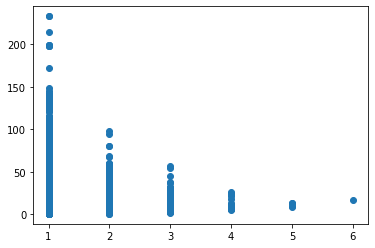

In [39]:
plt.scatter(num_purchase[num_purchase.Purchase==0].customerSessionId, num_purchase[num_purchase.Purchase==0].price)

## Splitting data into train and test sets

In [12]:
def random_split(data, user_id, item_id, metric, item_features=None):
  dataset = Dataset()
  dataset.fit(data[user_id], data[item_id], item_features=item_features)
  num_users, num_items = dataset.interactions_shape()
  print('Num users: {}, num_items {}.'.format(num_users, num_items))
  dataset.fit_partial(users=data[user_id], 
                     items=data[item_id],
                     item_features=item_features)
  fe = data.to_dict(orient='records')
  (interactions, weights) = dataset.build_interactions((x[user_id], x[item_id], x[metric]) for x in fe)
  (train, test) = random_train_test_split(interactions=interactions, test_percentage=0.2, random_state=2)
  print('Num values: {}'.format(len(interactions.data)))  
  return dataset, train, test, interactions

In [13]:
def calc_sparsity(data, user_id, item_id, metric):
    item_user_matrix = pd.DataFrame(data.pivot_table(index=[user_id], columns=item_id, values=metric))
    item_user_matrix.fillna(0,inplace=True)
    print('sparsity in data:',(1.0 - (np.count_nonzero(item_user_matrix) / float(item_user_matrix.size))))

In [17]:
dataset, train_g, test_g, interactions = random_split(num_purchase, 'customerVisitorId', 'ID', 'Purchase')

Num users: 44599, num_items 17480.
Num values: 997364


In [29]:
train_g.shape

(44599, 17480)

In [30]:
test_g.shape

(44599, 17480)

## Create dictionary to map user and item index

In [28]:
user_id_map, user_features, item_id_map, item_features = dataset.mapping()

In [31]:
item_id_map_rev = {int(v):k for k,v in item_id_map.items()}

In [32]:
user_id_map_rev = {int(v):k for k,v in user_id_map.items()}

In [107]:
train_g

<44599x17480 sparse matrix of type '<class 'numpy.int32'>'
	with 797891 stored elements in COOrdinate format>

In [108]:
test_g

<44599x17480 sparse matrix of type '<class 'numpy.int32'>'
	with 199473 stored elements in COOrdinate format>

In [89]:
calc_sparsity(num_purchase, 'customerVisitorId', 'ID', 'Purchase')

sparsity in data: 0.999594617954051


## LightFM model training

In [14]:
def model_fit_eval(loss, train, test, n_components, k_items, k=5, n=10, item_features=None):
  model = LightFM(no_components=n_components, loss=loss, item_alpha=1e-6, random_state=2, k=k, n=n)
  %time model.fit(train, epochs=10, num_threads=3, item_features=item_features)
  test_auc = auc_score(model, test, train_interactions=train, num_threads=3, item_features=item_features).mean()
  print('Collaborative filtering test AUC: %s' % test_auc)
  prec = precision_at_k(model, test, train_interactions=train, num_threads=3, k=k_items, item_features=item_features).mean()
  print('Collaborative filtering test precision: %s' % prec)
  recal = recall_at_k(model, test, train_interactions=train, num_threads=3, k=k_items, item_features=item_features).mean()
  print('Collaborative filtering test recall: %s' % recal)
  return model

In [34]:
model_g = model_fit_eval('warp', train_g, test_g, 128, 5)

CPU times: user 24.6 s, sys: 19.5 ms, total: 24.6 s
Wall time: 8.82 s
Collaborative filtering test AUC: 0.8918844
Collaborative filtering test precision: 0.38604438
Collaborative filtering test recall: 0.29490969857731075


In [41]:
#import boto3

#s3 = boto3.resource('s3')
#s3.meta.client.upload_file('./recdeployment/item_dist_mat.npz', 'groupby', 'interactions.npz')

## Recommending items

In [32]:
def similar_recommendation(model, interactions, user_id, user_dikt, 
                               item_dikt, item_dikt_rev, product_dict, threshold = 0, number_rec_items = 5):

    #Function to produce user recommendations

    n_items = len(item_dikt.keys())
    user_x = user_dikt[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = item_dikt.keys()
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    user_item_scores = interactions.toarray()[user_x]
    item_index = np.where(user_item_scores>0)[0]
    known_items = pd.DataFrame({ 'items': [item_dikt_rev[i] for i in item_index], 'scores':user_item_scores[item_index]}).sort_values('scores', ascending=False)
    
    scores = [x for x in scores if x not in known_items['items'].values]
    score_list = scores[0:number_rec_items]

    print("Items that were liked by the User:")
    counter = 1
    for i in range(len(known_items)):
        item = known_items.loc[i]['items']
        if str(product_dict[item]['name']) != 'nan':
            print(str(counter) + '- ' + str(product_dict[item]['name']) + ', ' + str(product_dict[item]['price']) + ', ' + product_dict[item]['collection'])
        else:
            print(str(counter) + '- ' + str(product_dict[item]['collection']))
        counter+=1

    print("\n Recommended Items:")
    counter = 1
    for i in score_list:
        if str(product_dict[i]['name']) != 'nan':
            print(str(counter) + '- ' + product_dict[i]['name'] + ', ' + str(product_dict[i]['price']) + ', ' + product_dict[i]["collection"]) 
        else:
            print(str(counter) + '- ' + product_dict[i]['collection'])
        counter+=1
#     return score_list

In [33]:
similar_recommendation(model, interactions, 'cjo06esrd00013gblo1n3haw7', user_id_map, 
                               item_id_map, item_id_map_rev, product_dic, threshold = 0, number_rec_items = 5)

Items that were liked by the User:
1- zinc picolinate - body preferred form, 2.99, Swanson Premium

 Recommended Items:
1- zinc citrate, 2.84, Swanson Premium
2- vitamin c with rose hips, 11.49, Swanson Premium
3- full spectrum saw palmetto, 9.49, Swanson Premium
4- full spectrum ashwagandha, 5.79, Swanson Premium
5- omega-3 fish oil - lemon flavor, 6.99, Swanson Premium


In [35]:
similar_recommendation(model, interactions, 'cjo09x89u00013gb80mn9xb57', user_id_map, 
                               item_id_map, item_id_map_rev, product_dic, threshold = 0, number_rec_items = 5)

Items that were liked by the User:
1- long-lasting deodorant stick - refreshing lavender, 5.89, NOW Foods

 Recommended Items:
1- 12 oz pwdr, 19.78, Swanson Ultra
2- mct oil - 100% pure pharmaceutical grade, 7.98, Swanson Ultra
3- acti-joint plus with krill oil, 13.18, Swanson Ultra
4- vitamin d-3 & k-2, 5.99, NOW Foods
5- chlorella complex, 17.99, Swanson Kyoto Brand


In [123]:
similar_recommendation(model_g, 'cjo6507qf00013ac37tbxxu8z', user_id_map, 
                               item_id_map, item_id_map_rev, dic, threshold = 0, number_rec_items = 5)

Items that were liked by the User:
1- 400 iu (10 mcg) 250 sgels, 3.99, Swanson Premium
2- longjax eurycoma longifolia jack extract, 18.99, Swanson Passion
3- high immunoglobulin colostrum, 18.39, default

 Recommended Items:
1- vitamin d3 - highest potency, 10.99, default
2- vitamin d3 - high potency, 4.79, default
3- super stress vitamin b-complex with vitamin c, 15.49, Swanson Premium
4- coq10 - high potency, 8.99, Swanson Ultra
5- zinc picolinate - body preferred form, 2.99, Swanson Premium


In [23]:
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
def item_emdedding_distance_matrix(model, item_dikt):

#     Function to create item-item distance embedding matrix

    df_item_norm_sparse = csr_matrix(model.item_embeddings)
    similarities = cosine_similarity(df_item_norm_sparse)
    item_emdedding_distance_matrix = pd.DataFrame(similarities)
    item_emdedding_distance_matrix.columns = item_dikt.keys()
    item_emdedding_distance_matrix.index = item_dikt.keys()
    return item_emdedding_distance_matrix

def also_bought_recommendation(item_emdedding_distance_matrix, item_id, 
                             product_dict, n_items = 5):

#     Function to create item-item recommendation

    recommended_items = list(pd.Series(item_emdedding_distance_matrix.loc[item_id,:]. \
                                  sort_values(ascending = False).head(n_items+1). \
                                  index[1:n_items+1]))
    
    print("Item of interest:")
    print(str(product_dict[item_id]['name']) + ', ' + str(product_dict[item_id]['price']) + ', ' + product_dict[item_id]['collection'])
    print("\n")
    print("Items that are frequently bought together:")
    counter = 1
    for i in recommended_items:
        if i in product_dict.keys():
            print(str(counter) + '- ' + str(product_dict[i]['name']) + ', ' + str(product_dict[i]['price']) + ', ' + product_dict[i]['collection'])
        else:
            print(str(counter) + '- ' + 'swansonhealthproduct')
        counter+=1
    #return recommended_items

In [24]:
item_dist = item_emdedding_distance_matrix(model, item_id_map)

In [177]:
also_bought_recommendation(item_dist, 'SW1113', dic)

Item of interest:
zinc picolinate - body preferred form, 2.99, Swanson Premium


Items that are frequently bought together:
1- zinc citrate, 2.84, Swanson Premium
2- vitamin d3 - high potency, 4.79, default
3- full spectrum saw palmetto, 9.49, Swanson Premium
4- vitamin c with rose hips, 11.49, Swanson Premium
5- triple magnesium complex, 11.99, Swanson Premium


In [180]:
also_bought_recommendation(item_dist, 'SWD015', dic)

Item of interest:
fat burner - 2 pack, 12.49, Swanson Best Weight-Control Formulas


Items that are frequently bought together:
1- fat burner, 7.99, Swanson Best Weight-Control Formulas
2- swansonhealthproduct
3- super fat burners extreme, 11.61, Natural Balance
4- swansonhealthproduct
5- full spectrum pterocarpus marsupium, 10.79, Swanson Premium


## Kaggle Cosmetics

In [15]:
all_features = pd.read_pickle("s3://groupby/data/dfCosmetics.pkl")

In [62]:
all_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20583955 entries, 0 to 20583954
Data columns (total 12 columns):
 #   Column          Dtype              
---  ------          -----              
 0   event_time      datetime64[ns, UTC]
 1   event_type      object             
 2   product_id      int64              
 3   category_id     int64              
 4   price           float64            
 5   user_id         int64              
 6   user_session    object             
 7   year            object             
 8   month           object             
 9   day             object             
 10  year_month_day  object             
 11  day_seq         int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(4), object(6)
memory usage: 2.0+ GB


In [101]:
all_features2 = all_features[(all_features.price>=11) & (all_features.price<=24)]

In [124]:
all_features2 = all_features[all_features.category_id == 1487580013950664926]

In [16]:
GroupUS = all_features.sort_values('event_time').groupby(['user_id', 'product_id'])

In [17]:
NumEventTime = GroupUS['event_type'].value_counts().unstack(fill_value = 0).rename(columns={'view':'NumTimesViewed','cart':'NumTimesCarted',
                                                                                        'purchase':'NumTimesPurchased','remove_from_cart' : 'NumTimesRemoved'})

In [18]:
data = NumEventTime.reset_index()
data['Purchase'] = data.NumTimesPurchased.apply(lambda x: 1 if x!=0 else 0)

In [19]:
other_data = GroupUS.agg({'price':'mean', 'user_session':'nunique', 'category_id':'first'}).reset_index()

In [20]:
data = data.merge(other_data, how='inner', on=['user_id', 'product_id'])

(array([9.557002e+06, 3.105470e+05, 1.182760e+05, 4.792400e+04,
        3.099900e+04, 2.572200e+04, 7.511000e+03, 2.069000e+03,
        4.323000e+03, 7.198000e+03]),
 array([5.00000e-02, 3.28230e+01, 6.55960e+01, 9.83690e+01, 1.31142e+02,
        1.63915e+02, 1.96688e+02, 2.29461e+02, 2.62234e+02, 2.95007e+02,
        3.27780e+02]),
 <BarContainer object of 10 artists>)

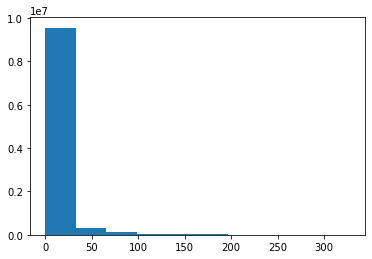

In [66]:
plt.hist(data.price)

In [86]:
data['price_category'] = np.where(data.price>=99, 'very expensive', np.where((data.price >= 66) & (data.price < 99), 'expensive', np.where((data.price >= 33) & (data.price<66), 'medium', 'cheap')))

In [85]:
data.head()

,user_id,product_id,NumTimesCarted,NumTimesPurchased,NumTimesRemoved,NumTimesViewed,Purchase,price,user_session,category_id
0,465496,5769989,0,0,0,1,0,10.00,1,1487580008447738866
1,465496,5865524,0,0,0,1,0,10.00,1,1487580008447738866
2,465496,5865526,0,0,0,1,0,10.00,1,1487580008447738866
3,1120748,5240,0,0,0,1,0,4.05,1,1487580009202712597
4,1180452,5881337,0,0,0,1,0,25.40,1,1487580012096782476


Text(0.5, 1.0, 'Kaggle Cosmetics Data Filter by Price')

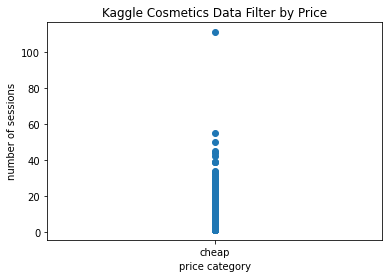

In [97]:
plt.scatter(data[(data.Purchase==1) & (data.price >= 11) & (data.price<=24)].price_category, data[(data.Purchase==1) &  (data.price >= 11) & (data.price<=24)].user_session)
plt.xlabel('price category')
plt.ylabel('number of sessions')
plt.title('Kaggle Cosmetics Data Filter by Price')

In [98]:
data[(data.Purchase==1) & (data.price >= 11) & (data.price<=24)].nunique()

user_id              38505
product_id            4366
NumTimesCarted          32
NumTimesPurchased       10
NumTimesRemoved         22
NumTimesViewed          53
Purchase                 1
price                 3640
user_session            41
category_id            252
price_category           1
dtype: int64

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.23361e+05, 1.46570e+04, 2.08600e+03, 4.64000e+02, 9.60000e+01,
        4.90000e+01, 5.00000e+00, 1.00000e+00, 8.00000e+00, 9.00000e+00]),
 array([  0.66 ,  23.914,  47.168,  70.422,  93.676, 116.93 , 140.184,
        163.438, 186.692, 209.946, 233.2  ]),
 <BarContainer object of 10 artists>)

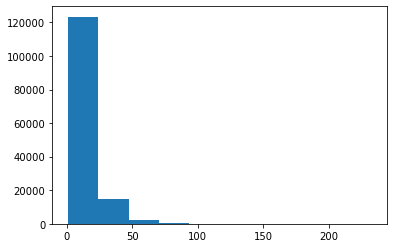

In [64]:
plt.hist(hits.price)

In [23]:
dataset_k, train, test, int_k = random_split(data, 'user_id', 'product_id', 'Purchase')

Num users: 1637770, num_items 53903.
Num values: 10111571


In [ ]:
calc_sparsity(data, 'user_id', 'product_id', 'Purchase')

In [ ]:
for n in [32, 64, 192]: 
    print(n)
    model_c = model_fit_eval('warp', train, test, n, 5)

32
CPU times: user 3min 12s, sys: 188 ms, total: 3min 12s
Wall time: 1min 15s


In [16]:
 model_c = model_fit_eval('warp-kos', train, test, 128, k=7, n=20)

CPU times: user 37 s, sys: 81.9 ms, total: 37 s
Wall time: 14.4 s
Collaborative filtering test AUC: 0.9077277
Collaborative filtering test precision: 0.043549385
Collaborative filtering test recall: 0.1560249026255479


## Kaggle Cosmetics + Groupby

In [48]:
data

event_type,user_id,product_id,NumTimesCarted,NumTimesPurchased,NumTimesRemoved,NumTimesViewed,Purchase
0,9794320,5706475,0,0,0,1,0
1,10280338,5876344,0,0,0,1,0
2,14297993,5804820,0,0,0,1,0
3,14297993,5882654,0,0,0,1,0
4,20554973,5706479,0,0,0,2,0
...,...,...,...,...,...,...,...
167790,622083330,5924482,0,0,0,1,0
167791,622083780,5846096,0,0,0,1,0
167792,622086358,5908170,0,0,0,1,0
167793,622086382,5804820,0,0,0,1,0


In [56]:
num_purchase2 = num_purchase.rename(columns={'customerVisitorId':"user_id", "ID":"product_id"})

In [57]:
num_purchase2

,user_id,product_id,numPurchase,price,Purchase
0,cjo06cah000013ea3jqwotb8g,AAM013,0,NaN,0
1,cjo06cah000013ea3jqwotb8g,AAM016,0,NaN,0
2,cjo06cah000013ea3jqwotb8g,AAM019,0,NaN,0
3,cjo06cah000013ea3jqwotb8g,ARG010,0,NaN,0
4,cjo06cah000013ea3jqwotb8g,DB088,0,NaN,0
...,...,...,...,...,...
997359,cki8fds6p000139dnzl8n11ln,SW106,5,9.76,1
997360,cki8h8bl300013bdvycc084d4,SWD015,0,12.49,0
997361,cki8i50go000139dbjuozjlpv,SWA051,3,14.79,1
997362,cki8pfl1y000139ebdeezn6pn,SWA051,3,14.79,1


In [58]:
combined = pd.concat([data[['user_id', 'product_id', 'Purchase']], num_purchase2[['user_id', 'product_id', 'Purchase']]], axis=0)

In [59]:
combined

event_type,user_id,product_id,Purchase
0,9794320,5706475,0
1,10280338,5876344,0
2,14297993,5804820,0
3,14297993,5882654,0
4,20554973,5706479,0
...,...,...,...
997359,cki8fds6p000139dnzl8n11ln,SW106,1
997360,cki8h8bl300013bdvycc084d4,SWD015,0
997361,cki8i50go000139dbjuozjlpv,SWA051,1
997362,cki8pfl1y000139ebdeezn6pn,SWA051,1


In [99]:
train_comb, test_comb = random_split(combined, 'user_id', 'product_id', 'Purchase')

Num users: 151533, num_items 17776.
Num values: 1165159


In [61]:
 model_comb = model_fit_eval('warp', train_comb, test_comb, 128 )

CPU times: user 31 s, sys: 49.7 ms, total: 31 s
Wall time: 11.4 s
Collaborative filtering test AUC: 0.94967175
Collaborative filtering test precision: 0.20758086
Collaborative filtering test recall: 0.31428044888114814


## Benchmark other data

In [3]:
from lightfm.datasets import fetch_movielens

data = fetch_movielens(min_rating=5.0)

In [11]:
model = LightFM(loss='warp', no_components=192, item_alpha=1e-6, random_state=2)
%time model.fit(data['train'], epochs=10, num_threads=3)

CPU times: user 987 ms, sys: 1.46 ms, total: 989 ms
Wall time: 337 ms


In [12]:
  test_auc = auc_score(model, data['test'], train_interactions=data['train'], num_threads=3).mean()
  print('Collaborative filtering test AUC: %s' % test_auc)
  prec = precision_at_k(model, data['test'], train_interactions=data['train'], num_threads=3, k=5).mean()
  print('Collaborative filtering test precision: %s' % prec)
  recal = recall_at_k(model, data['test'], train_interactions=data['train'], num_threads=3, k=5).mean()
  print('Collaborative filtering test recall: %s' % recal)

Collaborative filtering test AUC: 0.91579705
Collaborative filtering test precision: 0.073447816
Collaborative filtering test recall: 0.13724497284602966
